<h1>MNIST with a Twist</h1>

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame = False)

In [3]:
X, y  = mnist.data, mnist.target
print(X,X.shape)
print(y,y.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (70000, 784)
['5' '0' '4' ... '4' '5' '6'] (70000,)


In [4]:
print(type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


<h5>Explore a single digit

Label of our some digit is 5, <class 'str'>


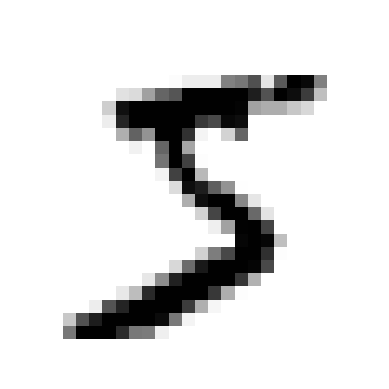

In [5]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image,cmap = "binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)

print(f"Label of our some digit is {y[0]}, {type(y[0])}")

<h5>astype() changes the dtype of the elements, not the container type.

In [6]:
print(type(y), type(y[0]))

<class 'numpy.ndarray'> <class 'str'>


In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

<h2>Binary CLassifier for a single digit</h2>
<p>lets pick a classifier and train it. Stochastic Gradient Descent(SGD) has an advantage of being capable of handling very large datasets efficiently because SGD deals with all the training instances independently, one at a time</p>

In [8]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train_5)


SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [11]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train,y_train_5)
print(any(dummy_clf.predict(X_train)))

cross_val_score(dummy_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

False


array([0.90965, 0.90965, 0.90965])

<h3>This accuracy tells us that only about 10% of images are of '5' and even if you predict not a 5 for every instance, you will be right for about 90% of the time</h3>

<h1>Confusion Matrix</h1>

In [12]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv = 3)
#cross_val_predict() preforms k-fold cross-validation and returns the predictions made on each test fold.

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

<p>53892 were correctly classified as not 5, hence true negatives</p>
<p>687 were classified as 5 but were not 5, hence false positives</p>
<p>1891 were classified as not 5 but were 5, hence false negatives</p>
<p>3530 were correctly classified as 5, hence true positives</p>

<h4>Example of a perfect classifier</h4>

In [14]:
y_perfect_pred = (y_train_5)
cm = confusion_matrix(y_train_5, y_perfect_pred)
cm

array([[54579,     0],
       [    0,  5421]])

<h4>A more concise metric would be  "precision" of the classifier. precision = TruePositives/(TruePositives+FalsePositives)</h4>
<h4>Precision is typically used with another metric called "recall" or "True Positive Rate(TPR)".recall =TruePositive/(TruePositive+FalseNegative) </h4>

In [15]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5,y_train_pred))

0.8370879772350012
0.6511713705958311


In [16]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

<h3>desicion_function method returns a score for each instance, we use it instead of predict() function. The score is kind of a threshold which we can use to make predictions</h3>

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


In [18]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


<p>This confirms that raising the threshold decreases reacll</p>

<h3>How do we decide which threshold to use?</h3>

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')
#With these scores we will use the "precision_recall_curve()" function to compute precision and recall for all possible threshold

In [20]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

<p>Default threshold (0 for SGD, 0.5 for probabilities) is arbitrary.</p>
<ul>This code lets you:
<li>choose a threshold for high precision (few false positives)</li>
<li>or for high recall (few missed positives)</li>
<li>or balance both (high F1)</li></ul>

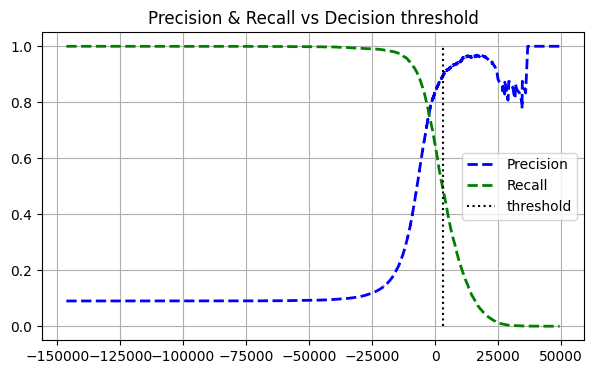

In [21]:
plt.figure(figsize=(7, 4))
plt.plot(thresholds, precisions[:-1], "b--", label = "Precision", linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g--", label = "Recall", linewidth = 2)
plt.vlines(threshold, 0,1.0,"k", "dotted", label = "threshold")
plt.title("Precision & Recall vs Decision threshold")
plt.grid()
plt.legend()
plt.show()


<h3>At this threshold, precision is around 90% and recall is about 50%</h3>
<h3>Another way is to plot precision directly against recall</h3>

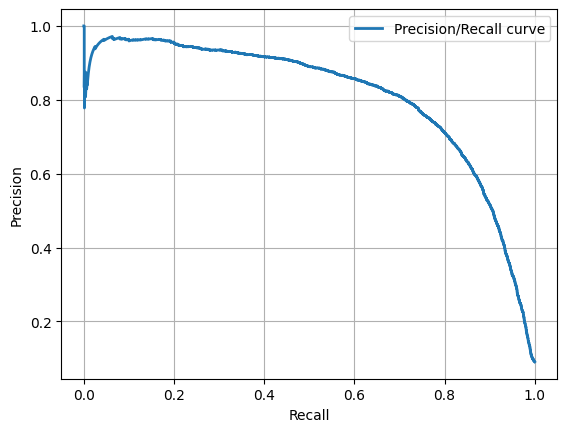

In [22]:
plt.plot(recalls, precisions, linewidth = 2, label = "Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()

<p>Precision starts to fall sharply at around 75% recall. WE probably should select a precision/recall trade-off just before that drop.(Depends on the project)</p>

In [23]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
print(threshold_for_90_precision)

#This code finds the decision threshold that gives you at least 90% precision and prints that threshold.


3370.019499144183


In [24]:
y_train_pred_90 = (y_scores>= threshold_for_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.9000345901072293


0.4799852425751706

<h1>ROC Curve</h1>

In [25]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

In [26]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90,fpr_90 = tpr[idx_for_threshold_at_90],fpr[idx_for_threshold_at_90]

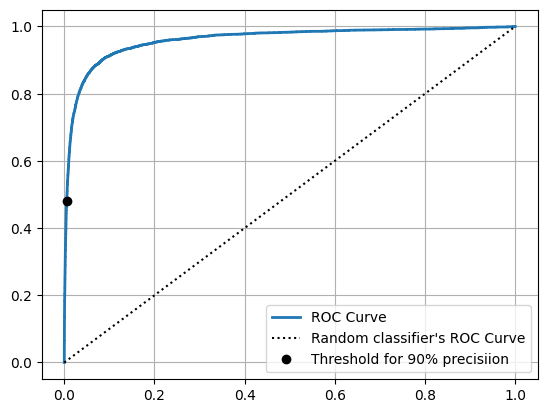

In [27]:
plt.plot(fpr,tpr, linewidth = 2, label = "ROC Curve")
plt.plot([0,1],[0,1], 'k:', label = "Random classifier's ROC Curve")
plt.plot([fpr_90],[tpr_90],"ko", label = "Threshold for 90% precisiion")
plt.legend()
plt.grid()
plt.show()

In [28]:
#Lets calculate the AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [29]:
#Lets compare SGD to Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)

In [30]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.98, 0.02]])

In [31]:
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

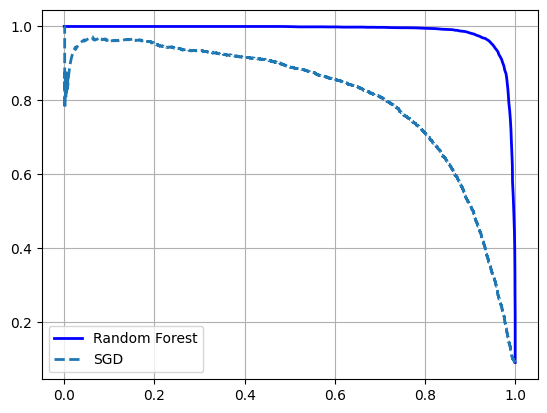

In [32]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth = 2, label = "Random Forest")
plt.plot(recalls, precisions, "--",linewidth = 2, label = "SGD")
plt.legend()
plt.grid()
plt.show()

<h3>RFC is better than SGD as its more towards/closer top-right corner and has greater AUC</h3>

In [33]:
y_train_pred_forest = y_probas_forest[:,1]>=0.5
f1_score(y_train_5, y_train_pred_forest)

0.9270445185330457

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983296721818179)

<h1>MULITCLASS CLASSIFICATION

In [35]:
from sklearn.svm import SVC

svm_clf = SVC(random_state = 42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [36]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [37]:
scores = svm_clf.decision_function([some_digit])
scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [38]:
class_id = scores.argmax()
class_id

np.int64(5)

In [39]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [40]:
svm_clf.classes_[class_id]

'5'

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))

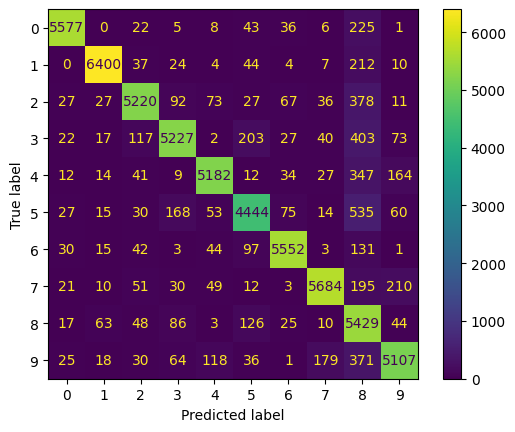

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred)
plt.show()

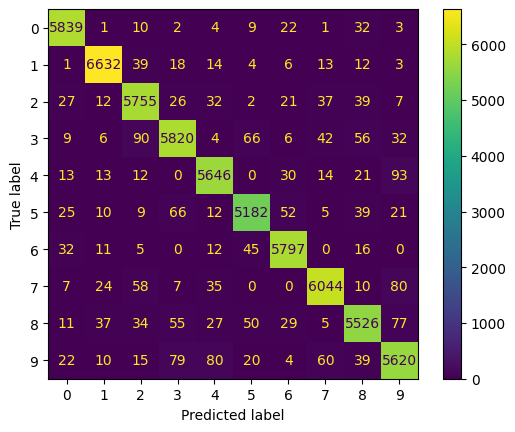

In [43]:
y_train_pred_rfc = cross_val_predict(forest_clf, X_train_scaled, y_train, cv = 3)
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred_rfc)
plt.show()

<h1>Building a classifier that achieves over 97% accuracy</h1>

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

In [47]:
knn_clf.fit(X_train_scaled,y_train)

KNeighborsClassifier()

In [48]:
y_train_pred_knn = cross_val_predict(knn_clf,X_train_scaled,y_train, cv = 3)
y_train_pred_knn

array(['3', '0', '4', ..., '5', '6', '8'], shape=(60000,), dtype=object)

In [49]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred_knn)


array([[5826,    4,   17,    6,    1,   17,   40,    4,    5,    3],
       [   2, 6670,   18,    6,    8,    4,   17,   11,    4,    2],
       [  71,   66, 5534,   92,   33,    8,   50,   53,   36,   15],
       [  13,   29,   57, 5789,    4,   79,    7,   68,   52,   33],
       [   9,   75,   54,    9, 5416,   17,   23,   29,    9,  201],
       [  33,   17,   15,  168,   16, 4984,   88,   13,   39,   48],
       [  61,   16,   21,    3,   14,   48, 5747,    1,    7,    0],
       [  12,   64,   25,   18,   78,    2,    0, 5854,    3,  209],
       [  57,   88,   52,  121,   48,  217,   32,   21, 5140,   75],
       [  20,   15,   22,   54,  127,   13,    0,  214,   22, 5462]])

In [50]:
from sklearn.metrics import classification_report

classification_report(y_train, y_train_pred_knn)

'              precision    recall  f1-score   support\n\n           0       0.95      0.98      0.97      5923\n           1       0.95      0.99      0.97      6742\n           2       0.95      0.93      0.94      5958\n           3       0.92      0.94      0.93      6131\n           4       0.94      0.93      0.93      5842\n           5       0.92      0.92      0.92      5421\n           6       0.96      0.97      0.96      5918\n           7       0.93      0.93      0.93      6265\n           8       0.97      0.88      0.92      5851\n           9       0.90      0.92      0.91      5949\n\n    accuracy                           0.94     60000\n   macro avg       0.94      0.94      0.94     60000\nweighted avg       0.94      0.94      0.94     60000\n'

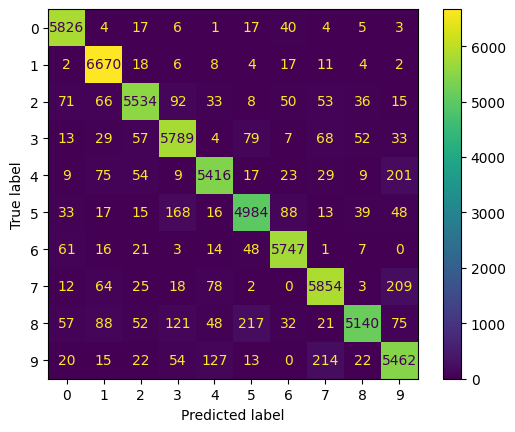

In [51]:
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred_knn)

In [55]:
from sklearn.metrics import f1_score

f1_macro = f1_score(y_train, y_train_pred_knn, average="macro")
f1_macro

0.9396793112547043

In [56]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_pred_knn))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5923
           1       0.95      0.99      0.97      6742
           2       0.95      0.93      0.94      5958
           3       0.92      0.94      0.93      6131
           4       0.94      0.93      0.93      5842
           5       0.92      0.92      0.92      5421
           6       0.96      0.97      0.96      5918
           7       0.93      0.93      0.93      6265
           8       0.97      0.88      0.92      5851
           9       0.90      0.92      0.91      5949

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000



In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=  19.1s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=  14.2s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=  13.2s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=  13.3s
[CV] END ...metric=euclidean, n_neighbors=9, weights=uniform; total time=  14.4s
[CV] END ..metric=euclidean, n_neighbors=9, weights=distance; total time=  10.8s
[CV] END ..metric=manhattan, n_neighbors=3, weights=distance; total time= 7.1min
[CV] END ..metric=manhattan, n_neighbors=3, weights=distance; total time= 7.2min
[CV] END ..metric=manhattan, n_neighbors=5, weights=distance; total time= 6.9min
[CV] END ...metric=manhattan, n_neighbors=7, weights=uniform; total time= 6.8min
[CV] END ...metric=manhattan, n_neighbors=9, weights=uniform; total time= 6.9min
[CV] END ..metric=euclidean, n_neighbors=3, weig

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='f1_macro', verbose=2)

In [58]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [59]:
best_knn = grid_search.best_estimator_

In [60]:
grid_search.best_score_

np.float64(0.9591604731151143)

[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=  18.8s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=  19.6s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=  19.2s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=  19.2s
[CV] END ..metric=euclidean, n_neighbors=9, weights=distance; total time=  10.3s
[CV] END ..metric=manhattan, n_neighbors=3, weights=distance; total time= 7.4min
[CV] END ...metric=manhattan, n_neighbors=5, weights=uniform; total time= 8.2min
[CV] END ..metric=manhattan, n_neighbors=5, weights=distance; total time= 6.9min
[CV] END ..metric=manhattan, n_neighbors=7, weights=distance; total time= 6.9min
[CV] END ..metric=manhattan, n_neighbors=9, weights=distance; total time= 6.8min
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=  19.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=  13.8s
[CV] END ..metric=euclidean,

In [63]:
X_test_scaled = scaler.fit_transform(X_test.astype("float64"))
y_test_pred = best_knn.predict(X_test_scaled)

In [ ]:
ConfusionMatrisDisplay.from_predictions(y_test, y_test_pred)

In [ ]:
ConfusionMatrisDisplay.from_predictions(y_test, y_test_pred)

In [66]:
import pandas as pd

results = pd.DataFrame(grid_search.cv_results_)
results[
    ["params", "mean_test_score", "std_test_score", "rank_test_score"]
].sort_values("rank_test_score").head(10)


,params,mean_test_score,std_test_score,rank_test_score
11,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.959160,0.001862,1
9,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.959022,0.001418,2
10,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.957658,0.001888,3
8,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.957534,0.001307,4
13,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",0.957276,0.001741,5
12,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",0.955810,0.001950,6
15,"{'metric': 'manhattan', 'n_neighbors': 9, 'wei...",0.955643,0.002097,7
14,"{'metric': 'manhattan', 'n_neighbors': 9, 'wei...",0.953818,0.002172,8
3,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.943762,0.002731,9
1,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",0.943685,0.002243,10


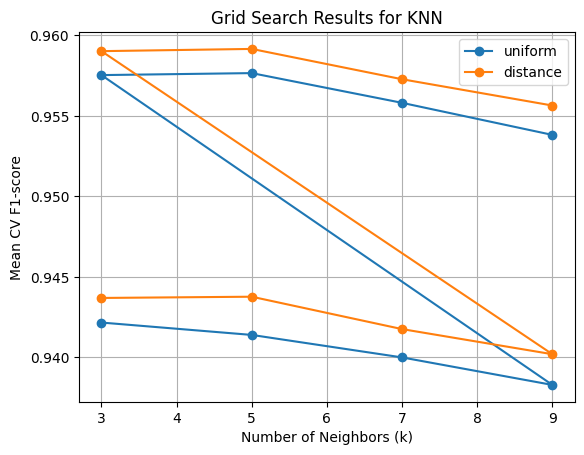

In [67]:
param_grid = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"]
}
import matplotlib.pyplot as plt

for weight in ["uniform", "distance"]:
    subset = results[results["param_weights"] == weight]
    plt.plot(
        subset["param_n_neighbors"],
        subset["mean_test_score"],
        marker="o",
        label=weight
    )

plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean CV F1-score")
plt.title("Grid Search Results for KNN")
plt.legend()
plt.grid(True)
plt.show()


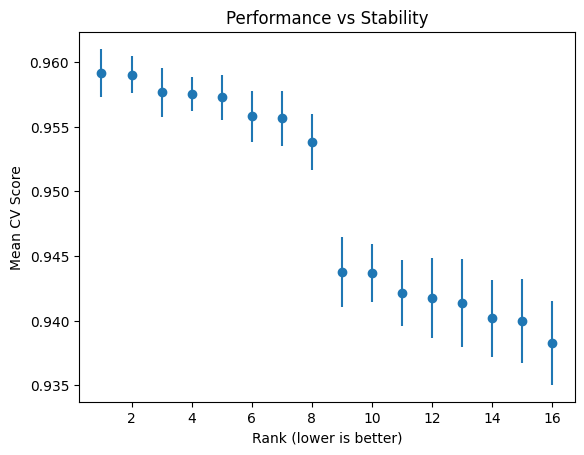

In [70]:
plt.errorbar(
    results["rank_test_score"],
    results["mean_test_score"],
    yerr=results["std_test_score"],
    fmt="o"
)

plt.xlabel("Rank (lower is better)")
plt.ylabel("Mean CV Score")
plt.title("Performance vs Stability")
plt.show()
